## Predictive modelling of player prices on Football Index

What accuracy can we expect if we solely try to model player price for predictive accuracy using our sparse features?

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

First, we load in our cleaned data and generate polynomial features. Polynomial features are included, as explained in the previous notebook, since we suspect logically that these interactions may have a significant correlation with price.

In [11]:
# Import model data
path = 'file:///C:/Users/micha/Documents/Quant/football_index/model_data.csv'
df = pd.read_csv(path)
df.set_index('PlayerName', inplace=True)

# Gen X and y matrices/vectors, leaving out forward to avoid multicollinearity problems
y_col = 'CurrentPrice'
X_cols = ['ave_matchday_score',
          'Age',
          'num_games_played',
          'Midfielder',
          'Defender',
          'Goalkeeper']

# Slice off target vector
y = df[y_col]

# Generate polynomial features, and scale the feature matrix
X_df = df[X_cols]

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_X = poly.fit_transform(X_df)

# Feature scaling since we are using regularisation
scaler = StandardScaler()
scaled_X = scaler.fit_transform(poly_X)

# Drop squares and interactions of indicator variables
feature_names = poly.get_feature_names(X_cols)[:-6]
X = np.delete(scaled_X, slice(-6, None), axis=1)

Next we train test split our data, plotting distributions of the training and testing set.
We do this as a precaution, since we are using a dataset that has a fairly positive skew toward lower player prices, we want to make sure that this is captured, especially in the test set of the data, so we do not get unreasonably optimistic estimates for our evaluation metric if the test set does not include these outlying players. 

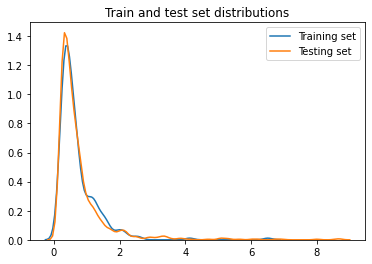

In [14]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Check stratification of train test since we have a skewed dataset and due to what 
# error metric we're using
fig, ax = plt.subplots()
ax.set_title('Train and test set distributions')
sns.kdeplot(y_test, label='Training set', ax=ax)
sns.kdeplot(y_train, label='Testing set', ax=ax);

## Model Building

#### Model 1: Benchmark linear regression

As a benchmark we check fit quality of a polynomial linear regression. We will be using mean absolute error (MAE) as our evaluation metric of choice, since when examening our dataset, we find it fairly positively skewed, with some 'star' players being quoted at far higher prices than others. These players are priced highly while not seemingly proportionally outperforming their competition, so we do not want our model to over-weight these outlying datapoints.  

In [17]:
# Train vanilla model
lm = LinearRegression()
model_1 = lm.fit(X_train, y_train)
coeffs = model_1.coef_

np.mean(cross_val_score(lm, X_train, y_train, scoring='neg_mean_absolute_error'))

-0.35024912445630174

Since this is a vanilla linear model with scaled features, we are easily able to check feature importance by directly comparing coefficients from the model. This can be used to see if identify any possible dead weight among our features.

In [1]:
# Feature importance mapped out. Since we have scaling in the pipeline we can do this...
feature_importance = pd.Series(coeffs, index=feature_names).abs().sort_values(ascending=False)

# Plotting feature importance...
feature_importance.plot.bar(title='Feature importance');

NameError: name 'pd' is not defined

Considering the plot above, a regularised linear regression may help our original model by disregarding some of the seemingly unimportant interaction terms toward the right hand side of the plot, which could be offering more noise than signal to the model. Therefore, we opt to try a lasso-style regression, which uses a regularisation term to penalise using non-zero coefficients within the linear model. This will cause the model to assign less weight to, or drop entirely features if they are unimportant.

#### Model 2: LASSO

In [25]:
# MODEL 2: LASSO

# Using k-fold cv to find optimal alpha
lasso = Lasso()

# mae since we know we have outliers, we don't want to fit to these too much
lasso_grid = {'alpha': list(np.arange(0.005, 1, 0.005))}
model_2 = GridSearchCV(lasso, lasso_grid, scoring='neg_mean_absolute_error')

results = model.fit(X_train, y_train)

print(results.best_params_)
print(results.best_score_)

{'alpha': 0.005}
-0.3518986383151682


When grid search optimising the regularisation term in our lasso regression, it is clear we dont have excessive model complexity here for our modest amount of training data. Including no regularisation (alpha=0) appears to offer better fit than including any atall. Therefore, we decide to try increasing model complexity to gain performance.

We will now try a random forest regression to attempt to capture some more subtle non-linearities and interactions between our features that are important to our target variable.

Note that, since we have seen that the polynomial features used in the above regressions are generally fairly useful to the above models, we pass these directly to our random forest regressor. We do this so that it does not have to learn to generate these features itself, it can simply choose to include or discard features as the algorithm decides. This will hopefully add to model performance.

In [26]:
# First use default sklearn rf hyper-parameters
rf = RandomForestRegressor(n_jobs=-1)
np.mean(cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error'))

-0.34594201208041664

From this first attempt there is not much improvement in model performance over a simple linear regression, so we try tuning a few hyperparameters to see if we can improve model performance.

Since our random forest model is far more complex than the above models, but provides only slightly improved cross-validation accuracy, we suspect that overfitting may be hindering performance. Therefore we focus on tuning parameters associated with model complexity.  

As we are fairly unsure of what values may be near optimal for our fairly small and very specialised dataset, we first use a randomized search to narrow down our options. 

In [28]:
# Narrow down your options
random_grid = {'max_depth': np.arange(5, 50),
               'min_samples_split': np.arange(2, 50),
               'max_leaf_nodes': np.arange(5, 100)}  # wide net

random_search = RandomizedSearchCV(rf, random_grid, 
                           scoring='neg_mean_absolute_error', random_state=42,
                           n_iter=25)
results_1 = random_search.fit(X_train, y_train)

print(results_1.best_params_)
print(results_1.best_score_)

{'min_samples_split': 13, 'max_leaf_nodes': 68, 'max_depth': 27}
-0.3469915068635177


Now we have some initial estimates of what good hyperparameter selections look like for our application, we can use a grid search that tests all combinations of values around these initial estimates, to try to find at least a local optimum solution. 

In [31]:
# Final tune
param_grid = {'max_depth': np.arange(22, 33, 2),
               'min_samples_split': np.arange(8, 19, 2),
               'max_leaf_nodes': np.arange(63, 74, 2)}  # narrow net

grid_search = GridSearchCV(rf, param_grid, scoring='neg_mean_absolute_error')
results_2 = grid_search.fit(X_train, y_train)
print(results_2.best_params_)
print(results_2.best_score_)

{'max_depth': 28, 'max_leaf_nodes': 65, 'min_samples_split': 8}
-0.34500163465126654


We appear to; without adding extra data or features, maxed out our RF model for the purpose of most accurately predicting football index player prices. 

Despite our random forest model having slightly better cross validation accuracy, we select our original linear regression as candidate model. We do this for 2 reasons...

- Occams protocol. Given equitable performance, a simple model is better than a complex model.
- Explicit is better than implicit. How a linear model produces predictions is far more explicit than the random forest, which is an additional bonus.

### Candidate model performance and conclusion

In [32]:
# Final results
final_model = LinearRegression().fit(X_train, y_train)

y_pred_test = model.predict(X_test)
mean_absolute_error(y_test, y_pred_test)

0.28332005619362893

As we can see, our linear model seems to generalise quite well, which we would expect given its simplicity. It achieves an MAE of around £0.28 when predicting player prices in the test set. 

Taking into account all the results from above, we have likely exhausted most predictive power out of our sparse features, so if significant improvements were to be made, collecting more features would likely be our best bet. A metric for player popularity, proxied by social media followers for example, could be a good predicter to use when explaining these extremely highly priced outlying players.